In [1]:
import json
import time
import sys
import os
import random
import warnings
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

In [2]:
# Results from the experiments
x = [4, 8, 12, 16, 20]
data = [
{'recency': {'acc': [0.55, 0.59, 0.64, 0.53, 0.54], 'bias': [0.2, 0.0975609756097561, 0.0, 0.02127659574468085, 0.0]},
 'authority': {'acc': [0.48, 0.48, 0.62, 0.63, 0.57], 'bias': [0.19230769230769232, 0.057692307692307696, 0.13157894736842105, 0.13513513513513514, 0.20930232558139536]},
 'label': 'LLaVA-NeXT Mistral-7B',
},
{'recency': {'acc': [0.53, 0.58, 0.55, 0.47, 0.43], 'bias': [0.40425531914893614, 0.23809523809523808, 0.28888888888888886, 0.16981132075471697, 0.2631578947368421]},
 'authority': {'acc': [0.53, 0.53, 0.49, 0.52, 0.48], 'bias': [0.2553191489361702, 0.23404255319148937, 0.47058823529411764, 0.5208333333333334, 0.5]},
 'label': 'MobileVLM_V2 7B',
},
{'recency': {'acc': [0.54, 0.58, 0.59, 0.53, 0.5], 'bias': [0.391304347826087, 0.3333333333333333, 0.2926829268292683, 0.2127659574468085, 0.28]},
 'authority': {'acc': [0.61, 0.43, 0.56, 0.59, 0.61], 'bias': [0.10256410256410256, 0.12280701754385964, 0.1590909090909091, 0.2682926829268293, 0.07692307692307693]},
 'label': 'Mini-Gemini 7B HD',
},
{'recency': {'acc': [0.54, 0.63, 0.57, 0.52, 0.54], 'bias': [0.2391304347826087, 0.05405405405405406, 0.16279069767441862, 0.10416666666666667, 0.06521739130434782]},
 'authority': {'acc': [0.47, 0.45, 0.54, 0.48, 0.6], 'bias': [0.4339622641509434, 0.45454545454545453, 0.5869565217391305, 0.6538461538461539, 0.65]},
 'label': 'MiniCPM-Llama3-V 2.5',
},
{'recency': {'acc': [0.51, 0.63, 0.61, 0.55, 0.58], 'bias': [0.30612244897959184, 0.16216216216216217, 0.2564102564102564, 0.08888888888888889, 0.11904761904761904]},
 'authority': {'acc': [0.54, 0.41, 0.52, 0.49, 0.45], 'bias': [0.13043478260869565, 0.1694915254237288, 0.22916666666666666, 0.35294117647058826, 0.2909090909090909]},
 'label': 'Phi-3-vision-128k-instruct',
},
{'recency': {'acc': [0.58, 0.66, 0.62, 0.51, 0.55], 'bias': [0.023809523809523808, 0.029411764705882353, 0.0, 0.04081632653061224, 0.0]},
 'authority': {'acc': [0.54, 0.48, 0.59, 0.67, 0.63], 'bias': [0.043478260869565216, 0.0, 0.024390243902439025, 0.0, 0.0]},
 'label': 'GPT-4o',
},
{'recency': {'acc': [0.56, 0.64, 0.61, 0.51, 0.5], 'bias': [0.22727272727272727, 0.16666666666666666, 0.20512820512820512, 0.24489795918367346, 0.26]},
 'authority': {'acc': [0.56, 0.49, 0.58, 0.68, 0.61], 'bias': [0.06818181818181818, 0.0196078431372549, 0.047619047619047616, 0.0, 0.02564102564102564]},
 'label': 'Claude-3.5-sonnet',
},
{'recency': {'acc': [0.57, 0.67, 0.63, 0.5, 0.49], 'bias': [0.046511627906976744, 0.030303030303030304, 0.02702702702702703, 0.06, 0.058823529411764705]},
 'authority': {'acc': [0.51, 0.43, 0.58, 0.62, 0.56], 'bias': [0.1836734693877551, 0.14035087719298245,  0.30952380952380953, 0.3157894736842105, 0.2727272727272727]},
 'label': 'Gemini-1.5-pro',
},
]

In [3]:
columns = pd.MultiIndex.from_tuples([('recency', 'acc', 'mean'), ('recency', 'acc', 'std'),
                                     ('recency', 'bias', 'mean'), ('recency', 'bias', 'std'),
                                     ('authority', 'acc', 'mean'), ('authority', 'acc', 'std'),
                                     ('authority', 'bias', 'mean'), ('authority', 'bias', 'std'),
                                    ],
                                     names=['bias_type', 'metric', 'stats']
)
stats = pd.DataFrame(index=[model['label'] for model in data], columns=columns)
for model in data:
    recency_acc_mean = np.mean(np.array(model['recency']['acc']) * 100)
    recency_acc_std = np.std(np.array(model['recency']['acc']) * 100)
    recency_bias_mean = np.mean(np.array(model['recency']['bias']) * 100)
    recency_bias_std = np.std(np.array(model['recency']['bias']) * 100)
    authority_acc_mean = np.mean(np.array(model['authority']['acc']) * 100)
    authority_acc_std = np.std(np.array(model['authority']['acc']) * 100)
    authority_bias_mean = np.mean(np.array(model['authority']['bias']) * 100)
    authority_bias_std = np.std(np.array(model['authority']['bias']) * 100)
    stats.loc[model['label']] = [recency_acc_mean, recency_acc_std, recency_bias_mean, recency_bias_std,
                                authority_acc_mean, authority_acc_std, authority_bias_mean, authority_bias_std]
stats

bias_type                  recency                                authority  \
metric                         acc                 bias                 acc   
stats                         mean       std       mean       std      mean   
LLaVA-NeXT Mistral-7B         57.0  4.049691   6.376751  7.699267      55.6   
MobileVLM_V2 7B               51.2  5.455273  27.284173  7.673774      51.0   
Mini-Gemini 7B HD             54.8  3.310589  30.201731  5.914485      56.0   
MiniCPM-Llama3-V 2.5          56.0  3.847077  12.507185  6.854952      50.8   
Phi-3-vision-128k-instruct    57.6  4.270831  18.652628  8.230073      48.2   
GPT-4o                        58.4   5.23832   1.880752  1.630523      58.2   
Claude-3.5-sonnet             56.4    5.4626  22.079311  3.266579      58.4   
Gemini-1.5-pro                57.2  7.054077   4.453304  1.382978      54.0   

bias_type                                                   
metric                                     bias             
stats                            std       mean        std  
LLaVA-NeXT Mistral-7B       6.529931  14.520328   5.342785  
MobileVLM_V2 7B             2.097618  39.615665  12.488712  
Mini-Gemini 7B HD           6.752777  14.593556   6.681776  
MiniCPM-Llama3-V 2.5        5.491812  55.586208   9.439737  
Phi-3-vision-128k-instruct  4.707441  23.458865   8.036713  
GPT-4o                      6.675328    1.35737   1.768625  
Claude-3.5-sonnet           6.216108   3.220995   2.354086  
Gemini-1.5-pro              6.542171  24.441298   7.021956

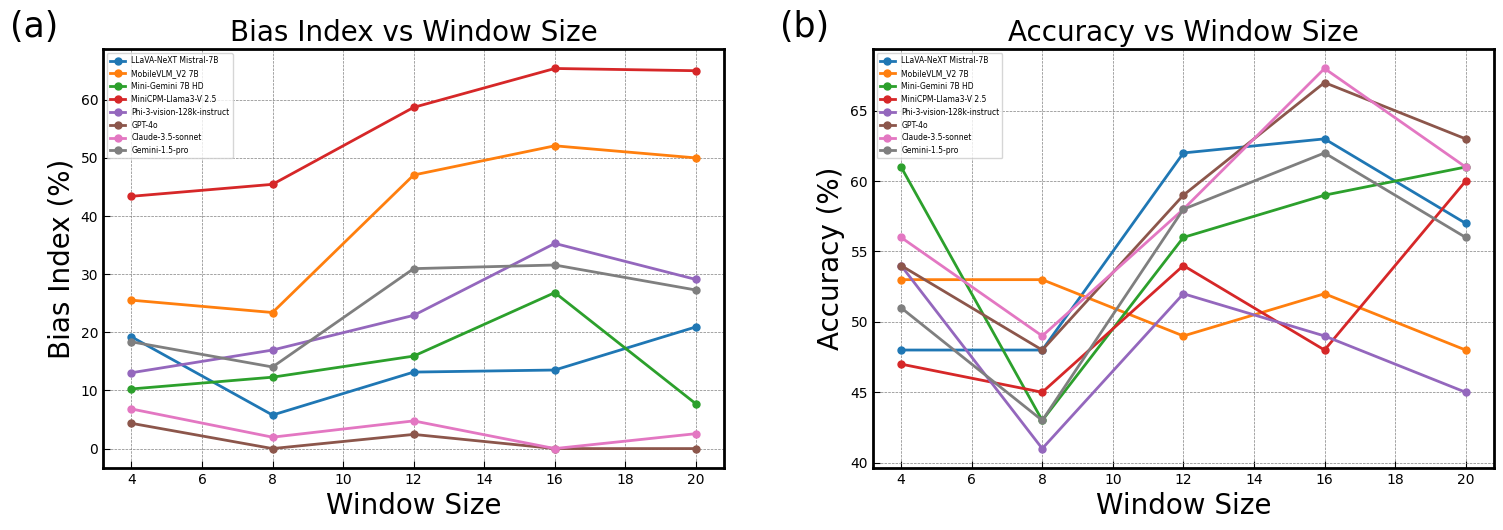

In [6]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5.4), dpi=100)
# bias_type = 'recency'
bias_type = 'authority'

# Plotting the lines
for model in data:
    axs[0].plot(x, np.array(model[bias_type]['bias']) * 100, label=model['label'], linewidth=2, linestyle='-', marker='o', markersize=5)
    axs[1].plot(x, np.array(model[bias_type]['acc']) * 100, label=model['label'], linewidth=2, linestyle='-', marker='o', markersize=5)

# Customizing the plot
axs[0].set_title('Bias Index vs Window Size', fontsize=20)
axs[0].set_xlabel('Window Size', fontsize=20)
axs[0].set_ylabel('Bias Index (%)', fontsize=20)
axs[0].tick_params(length=5, which='both', axis='both', direction='in')
axs[0].grid(True, linestyle='--', color='gray', linewidth=0.5)
axs[0].legend(prop={'size': 5.5})
axs[1].set_title('Accuracy vs Window Size', fontsize=20)
axs[1].set_xlabel('Window Size', fontsize=20)
axs[1].set_ylabel('Accuracy (%)', fontsize=20)
axs[1].tick_params(length=5, which='both', axis='both', direction='in')
axs[1].grid(True, linestyle='--', color='gray', linewidth=0.5)
axs[1].legend(prop={'size': 5.5})
axs[0].annotate('(a)', xy=(-0.15, 1.03), xycoords='axes fraction', fontsize=25)
axs[1].annotate('(b)', xy=(-0.15, 1.03), xycoords='axes fraction', fontsize=25)
for i in range(2):
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)
fig.tight_layout(w_pad=5)
# fig.subplots_adjust(top=0.85)
plt.show()
fig.savefig(f"./{bias_type}.pdf", format='pdf')